In [1]:
%matplotlib inline
import re
import string
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, Bidirectional
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D , MaxPooling2D

In [2]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [3]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [4]:
width = 60
height = 60
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6673/6987 [01:22<00:03, 83.88it/s]D:\Users\hp\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6987/6987 [01:25<00:00, 81.42it/s]


In [5]:
X.shape

(6982, 60, 60, 3)

In [6]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [7]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [8]:
import nlpaug
import nlpaug.augmenter.word as naw
from imgaug import augmenters as iaa
def Augmentation(text, images, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    augmented_images = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 'negative'
            temps = aug.augment(text.iloc[i],n=6)
            for j in range(6):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        elif np.argmax(labels.iloc[i]) == 1:
            t = 'neutral'
            temps = aug.augment(text.iloc[i],n=2)
            for j in range(2):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append('positive')
            augmented_images.append(images[i])
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences, augmented_images, augmented_sentences_labels

In [9]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
text, images, sent = Augmentation(cleaned.text_corrected, X, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [10]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
cleaned.shape, np.array(images).shape,target.shape

((12335, 2), (12335, 60, 60, 3), (12335, 3))

In [11]:
cleaned['sentiment'].value_counts()

neutral     4396
positive    4153
negative    3786
Name: sentiment, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size = 0.2, stratify=target)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [14]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [15]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
# base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
#                                                include_top=False,
#                                                weights='imagenet')

In [16]:
base_model_1.trainable = False
#base_model_2.trainable = False

In [17]:
def image_model():
    image_input = tf.keras.Input(shape=(60, 60, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    #layer_bm_1 = Dense(512)(layer_bm_1)
#     layer_bm_2 = base_model_2(image_input, training=False)
#     layer_bm_2 = Dense(512)(layer_bm_2)
#     layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layer_bm_1)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [18]:
image_input, image_layers = image_model()

In [19]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text'] = standardization(cleaned.text)

In [20]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 10000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [21]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [22]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
    
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
#     text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True))(text_layers)
#     text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

In [23]:
def model(layer_1, layer_2, image_input, text_input):
    average = tf.keras.layers.Average()([layer_1, layer_2])
    semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(average)

    prediction_layer = tf.keras.layers.Dense(3, activation='sigmoid', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [24]:
model = model(image_layers, text_layers, image_input, text_input)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 50, 16)       160000      ['text_vectorization[0][0]']     
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 1024)     2166784     ['embedding[0][0]']          

In [25]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
img = []
txt = []
for (i,j) in zip(X_train,X_text_train):
    img.append(i)
    txt.append(j)
#X = np.expand_dims(img, axis=0).astype(np.float32)
#X = preprocess_input(X)

In [26]:
conv_output = model.get_layer("average").output
pred_ouptut = model.get_layer("task_a").output

In [27]:
from tensorflow.keras.models import Model
mod = Model(model.input, outputs=conv_output)

In [28]:
im =tf.stack(img)
txt = tf.stack(txt)
# txt = np.expand_dims(txt, axis=0)
# im = np.expand_dims(img,axis=0)

In [29]:
im.shape

TensorShape([9868, 60, 60, 3])

In [30]:
conv = []
pred = []
for (i,j) in zip(im,txt):
    i = np.expand_dims(i, axis=0)
    j = np.expand_dims(j,axis=0)
    
    c= mod.predict(x = {"image_input": i, "text": j})
    conv.append(c)
    #pred.append(p)
# decode_predictions(pred)

1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 83ms/step


In [31]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd 

In [32]:
np.array(conv).shape

(9868, 1, 2048)

In [33]:
conv = reshape(conv, (9868, 2048))

In [34]:
tsne = TSNE(n_components=3, verbose=1, random_state=123)
z = tsne.fit_transform(conv) 

D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9868 samples in 0.024s...
[t-SNE] Computed neighbors for 9868 samples in 4.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9868
[t-SNE] Computed conditional probabilities for sample 2000 / 9868
[t-SNE] Computed conditional probabilities for sample 3000 / 9868
[t-SNE] Computed conditional probabilities for sample 4000 / 9868
[t-SNE] Computed conditional probabilities for sample 5000 / 9868
[t-SNE] Computed conditional probabilities for sample 6000 / 9868
[t-SNE] Computed conditional probabilities for sample 7000 / 9868
[t-SNE] Computed conditional probabilities for sample 8000 / 9868
[t-SNE] Computed conditional probabilities for sample 9000 / 9868
[t-SNE] Computed conditional probabilities for sample 9868 / 9868
[t-SNE] Mean sigma: 0.735838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.693848
[t-SNE] KL divergence after 1000 iterations: 2.443850


[Text(0.5, 1.0, 'T-SNE projection')]

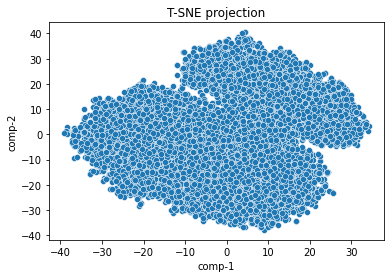

In [35]:
df = pd.DataFrame()
df["y"] = pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

In [36]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [37]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-1
    elif epoch >= 3 and epoch < 5:
        return 1e-2
    else:
        return 1e-5

In [38]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [39]:
X_train = tf.stack(X_train)
X_text_train = tf.stack(X_text_train)
y_train = tf.stack(y_train)

In [40]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = y_train,
                    batch_size=64,
                    epochs=7
                   )

Epoch 1/7
155/155 [==============================] - 121s 709ms/step - loss: 0.9983 - accuracy: 0.6903
Epoch 2/7
155/155 [==============================] - 111s 717ms/step - loss: 0.8922 - accuracy: 0.6930
Epoch 3/7
155/155 [==============================] - 211s 1s/step - loss: 0.8108 - accuracy: 0.6930
Epoch 4/7
155/155 [==============================] - 194s 1s/step - loss: 0.7476 - accuracy: 0.6930
Epoch 5/7
155/155 [==============================] - 196s 1s/step - loss: 0.6982 - accuracy: 0.6930
Epoch 6/7
155/155 [==============================] - 264s 2s/step - loss: 0.6595 - accuracy: 0.6930
Epoch 7/7
155/155 [==============================] - 187s 1s/step - loss: 0.6286 - accuracy: 0.6930


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


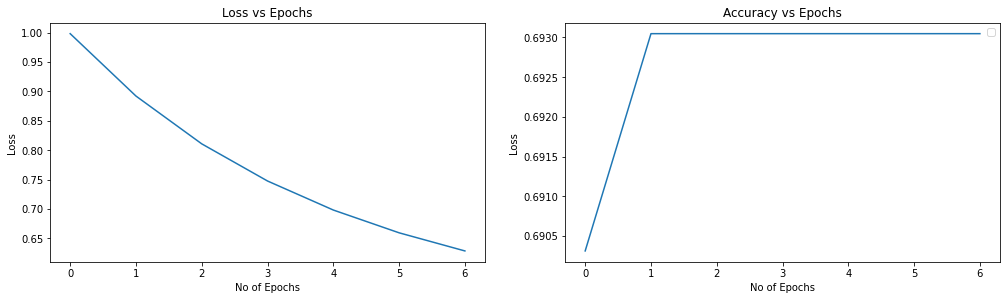

In [41]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(pd.DataFrame(history.history).loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(pd.DataFrame(history.history).accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()
plt.show()

In [42]:
X_test = tf.stack(X_test)
X_text_test = tf.stack(X_text_test)
y_test = tf.stack(y_test)

In [43]:
eval_ = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

78/78 [==============================] - 10s 104ms/step - loss: 0.6151 - accuracy: 0.6931


In [44]:
from sklearn.metrics import f1_score, classification_report
prediction = model.predict(x = {"image_input": X_test, "text": X_text_test})
prediction = np.array(prediction)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(prediction, axis = 1)))

78/78 [==============================] - 9s 95ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       757
           1       0.54      1.00      0.70       879
           2       1.00      1.00      1.00       831

    accuracy                           0.69      2467
   macro avg       0.51      0.67      0.57      2467
weighted avg       0.53      0.69      0.59      2467



D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
